# First, load data for testing

In [20]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import requests
import numpy as np

In [5]:
# Get a library of many compounds

url = "https://raw.githubusercontent.com/durrantlab/colab-support-files/main/SDF_Soluble_Diversity_Library_15500.smi"
response = requests.get(url)
file_content = response.text
print(file_content[:500])

Brc1ccc2c(c1)cc([nH]2)C(=O)N	5-bromo-1H-indole-2-carboxamide
O=C(C(N1CCN(CC1)c1ccccc1F)C)NC1CCCCC1	N-cyclohexyl-2-[4-(2-fluorophenyl)piperazin-1-yl]propanamide
O=C(C(C)(C)C)NCc1ccc(cc1)Cl	N-[(4-chlorophenyl)methyl]-2,2-dimethylpropanamide
O=C(c1c2CCCc2nc2c1cccc2)NC1CC1	N-cyclopropyl-1H,2H,3H-cyclopenta[b]quinoline-9-carboxamide
O=C(C(C)C)Nc1ccc(c(c1)C)Br	N-(4-bromo-3-methylphenyl)-2-methylpropanamide
O=C1NC2(CCCCCC2)Oc2c1cccc2	3,4-dihydrospiro[1,3-benzoxazine-2,1'-cycloheptan]-4-one
O=C(Nc1ccc(c


In [22]:
# Get the smiles strings

smiles = [line.split()[0] for line in file_content.split("\n") if line]

# Let's keep only 1000 entries
smiles = smiles[:1000]

smiles[:5]

['Brc1ccc2c(c1)cc([nH]2)C(=O)N',
 'O=C(C(N1CCN(CC1)c1ccccc1F)C)NC1CCCCC1',
 'O=C(C(C)(C)C)NCc1ccc(cc1)Cl',
 'O=C(c1c2CCCc2nc2c1cccc2)NC1CC1',
 'O=C(C(C)C)Nc1ccc(c(c1)C)Br']

In [23]:
# Convert to rdkit molecules

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
mols[:5]

# Determine "Ground Truth" and molecular features for training

In [24]:
# Calculate the predicted logp for each molecule

logps = [Descriptors.MolLogP(mol) for mol in mols]
logps[:5]

[2.0293000000000005,
 2.785100000000001,
 3.002300000000001,
 2.6157000000000004,
 3.352020000000002]

In [25]:
# We must create feature vectors for each molecule. We will use Morgan
# fingerprints as features.

# A Morgan fingerprint is a fixed-length bit vector that represents the presence
# of substructures in a molecule. It is a very popular method for representing
# molecules as features for machine learning.

morgan_fps = [np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in mols]
morgan_fps[:5]

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0])]

# Train Regressors to predict LogP

In [75]:
# Let's split the data into training and testing sets

from sklearn.model_selection import train_test_split

morgans_train, morgans_test, logps_train, logps_test = train_test_split(morgan_fps, logps, test_size=0.2, random_state=42)

print(morgans_train[:5])
print(logps_train[:5])

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
[2.617800000000001, 2.2121999999999993, 0.33230000000000115, 1.9333999999999998, 3.1076200000000016]


In [76]:
# Make a function for scatter plots

import matplotlib.pyplot as plt

def scatter(test, pred, err=0):
    # Graph the predicted vs actual logp values on the test set.

    plt.scatter(test, pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    fig = plt.gcf()
    fig.set_size_inches(4, 4)

    plt.show()

svm 0.30931518023135035


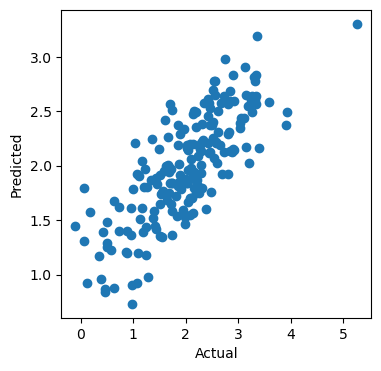


------------------------------------------------------------

GradientBoostingRegressor 0.4167014223860433


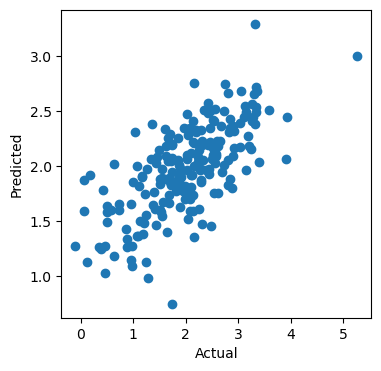


------------------------------------------------------------

RandomForestRegressor 0.43690519244715004


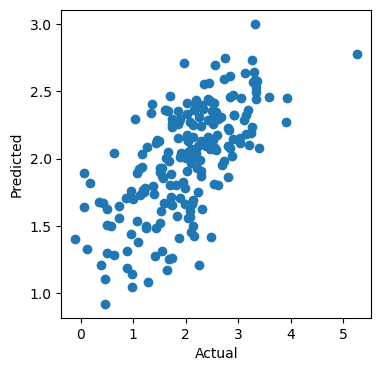


------------------------------------------------------------

KNeighborsRegressor 0.5461092164606672


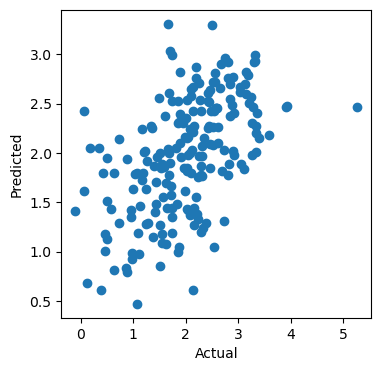


------------------------------------------------------------

DecisionTreeRegressor 0.8805842298660009


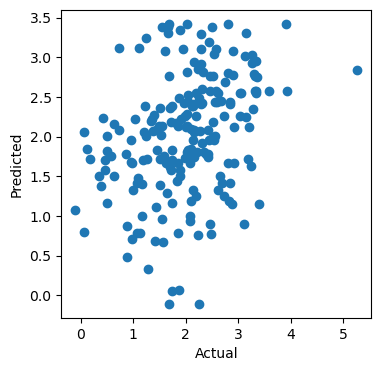


------------------------------------------------------------

GaussianProcessRegressor 4.72108458805677


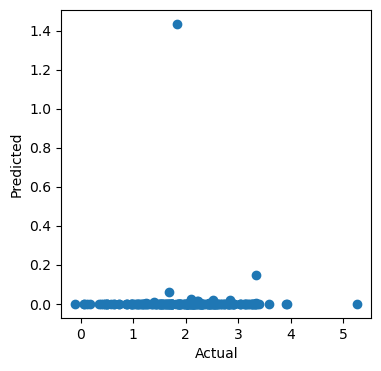


------------------------------------------------------------



In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# To learn more about these regressors, see:
# https://scikit-learn.org/stable/supervised_learning.html

regressors = [
    ["svm", svm.SVR()],
    ["GradientBoostingRegressor", GradientBoostingRegressor()],
    ["RandomForestRegressor", RandomForestRegressor(n_estimators=100, random_state=42)],
    ["KNeighborsRegressor", KNeighborsRegressor(n_neighbors=3)],
    ["DecisionTreeRegressor", DecisionTreeRegressor()],
    ["GaussianProcessRegressor", GaussianProcessRegressor()],
]

for name, regressor in regressors:
    # Use sklearn to train a regressor on the training data
    regressor.fit(morgans_train, logps_train)

    # Evaluate the regressor on the testing data
    logps_pred = regressor.predict(morgans_test)
    err = mean_squared_error(logps_test, logps_pred)

    print(name, err)
    scatter(logps_test, logps_pred)

    # Print separator
    print("\n" + "-"*60 + "\n")

# Now train classifiers

In [69]:
# Now let's train a classifier instead. We will use the same features, but
# we will discretize the logp values into 2 classes: above or below 2.

# Above or below 5
logps_class = np.array([1 if logp > 2 else 0 for logp in logps])

# Let's split the data into training and testing sets, as before
morgans_train, morgans_test, logps_class_train, logps_class_test = train_test_split(morgan_fps, logps_class, test_size=0.2, random_state=42)

logps_class_train[:20]

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0])

In [73]:
# Now let's train classifiers to predict which class a molecule belongs to

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# To learn more about these regressors, see:
# https://scikit-learn.org/stable/supervised_learning.html

classifiers = [
    ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, random_state=42)],
    ["svm", svm.SVC()],
    ["GradientBoostingClassifier", GradientBoostingClassifier()],
    ["GaussianProcessClassifier", GaussianProcessClassifier()],
    ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=3)],
    ["DecisionTreeClassifier", DecisionTreeClassifier()],
]

for name, classifier in classifiers:
    # Use sklearn to train a classifier on the training data
    classifier.fit(morgans_train, logps_class_train)

    # Evaluate the classifier on the testing data
    logps_class_pred = classifier.predict(morgans_test)
    acc = accuracy_score(logps_class_test, logps_class_pred)

    # Accuracy is the proportion of true results (both true positives and true
    # negatives) among the total number of cases examined.

    print(name, acc)

RandomForestClassifier 0.765
svm 0.76
GradientBoostingClassifier 0.74
GaussianProcessClassifier 0.68
KNeighborsClassifier 0.675
DecisionTreeClassifier 0.645
